### More Transfer Learning: SpaCy Transformers with Keras

In [1]:
import spacy

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

In [25]:
nlp = spacy.load('en_core_web_lg')

In [26]:
sentence = 'My dog sleeps on the bed.'

In [27]:
doc = nlp(sentence)

In [28]:
for token in doc:
    print(token.pos_)

DET
NOUN
VERB
ADP
DET
NOUN
PUNCT


### Pretrained Models

![](https://1.bp.blogspot.com/-RLAbr6kPNUo/W9is5FwUXmI/AAAAAAAADeU/5y9466Zoyoc96vqLjbruLK8i_t8qEdHnQCLcBGAs/s640/image3.png)

In [29]:
import spacy

In [30]:
#!python -m spacy download en_trf_bertbaseuncased_lg 

In [31]:
nlp = spacy.load("en_trf_bertbaseuncased_lg")

In [32]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # 0.73428553
print(apple1[0].similarity(apple3[0]))  # 0.43365782

0.7342852
0.433657


In [33]:
doc1 = nlp('My dogs sleep on the bed.')
doc2 = nlp('My dogs eat dinner in the garage.')
doc3 = nlp('My dogs are ride or die.')

In [34]:
for token in doc3:
    print(token.text, token.pos_, token.tag_, token.is_stop)

My   True
dogs   False
are   True
ride   False
or   True
die   False
.   False


In [35]:
doc1.similarity(doc2)

0.8494800354230787

In [36]:
doc1.similarity(doc3)

0.6500362364856437

### Training a Model

In [37]:
#load in the data
pitch_df = pd.read_csv('pitch_sample.csv', index_col = 0)

In [38]:
#take a peek
pitch_df.head()

,artists,album,text,score,genre,time
6769,Oval,Calidostópia!,The result of a 10-day recording session in Sa...,6.8,Electronic,March 22 2013
18490,The Folk Implosion,The New Folk Implosion,"Guys, could I have a minute to talk with Lou i...",4.6,Experimental,March 11 2003
8295,The Soft Moon,Total Decay EP,San Francisco's Luis Vasquez returns with anot...,7.8,Rock,October 31 2011
2885,Steve Aoki,4OKI,"Steve Aoki’s latest EP,",2.5,Electronic,August 2 2016
6081,Pinkish Black,Razed to the Ground,Fort Worth duo Pinkish Black flip the idea of ...,7.2,Rock,October 1 2013


In [50]:
#parameters for tokenization
max_len = 100
training_samples = 200
validation_samples = 1000
max_words = 10_000

#instantiate the tokenizer
tokenizer = Tokenizer(num_words = max_words)

#fit the tokenizer
tokenizer.fit_on_texts(pitch_df['text'])

#create the sequences
sequences = tokenizer.texts_to_sequences(pitch_df['text'])

#pad sequences
data = pad_sequences(sequences, maxlen = max_len)

In [51]:
sequences[:1]

[[1, 620, 3, 4, 419, 324, 388, 977, 6, 3817, 978, 3818, 6, 2309, 162]]

In [52]:
#y is score
y = pitch_df['score']

In [57]:
#create train/test sets
x_train = data[:training_samples]
x_test = data[training_samples: training_samples + validation_samples]

y_train = y[:training_samples]
y_test = y[training_samples: training_samples + validation_samples]

#simple network model
model = Sequential()
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1))

#compile
model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse'])

#fit
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs = 50, verbose = 0)

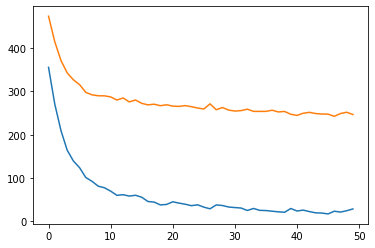

In [58]:
#examine the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

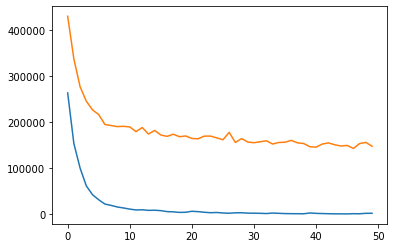

In [59]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

### Keras and BERT

In [ ]:
#!pip install spacy-transformers

In [60]:
from sklearn.base import TransformerMixin, BaseEstimator

In [69]:
#a custom transformer class
class WordVectorTransformer(TransformerMixin, BaseEstimator):
    
    def __init__(self, model = "en_trf_bertbaseuncased_lg"):
        self.model = model
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])
        

In [70]:
doc1

My dogs sleep on the bed.

In [71]:
doc1.vector.shape

(768,)

In [72]:
#make a pipeline
pipe1 = make_pipeline(WordVectorTransformer(), LinearRegression())

In [73]:
#train/test split the sklearn way
X = pitch_df['text']
y = pitch_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [74]:
#fit it
pipe1.fit(X_train, y_train)

Pipeline(steps=[('wordvectortransformer', WordVectorTransformer()),
                ('linearregression', LinearRegression())])

In [75]:
#score it
pipe1.score(X_train, y_train)

0.5308780918768408

In [76]:
pipe1.score(X_test, y_test)

0.5358126959959912

### Trying other estimators

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
#make a pipeline
pipe2 = make_pipeline(WordVectorTransformer(), 
                      RandomForestRegressor(max_depth=5))

In [82]:
#fit it
pipe2.fit(X_train, y_train)

Pipeline(steps=[('wordvectortransformer', WordVectorTransformer()),
                ('randomforestregressor', RandomForestRegressor(max_depth=5))])

In [83]:
#train score
pipe2.score(X_train, y_train)

0.3051814399679872

In [84]:
#test score
pipe2.score(X_test, y_test)

0.12452841940580517

### Keras and sklearn

In [100]:
from keras.callbacks import CSVLogger

In [101]:
hist_callback = CSVLogger('test.csv', append = True)

In [102]:
#add a callback
callback = EarlyStopping(monitor = 'loss', patience = 5)
hist_callback = CSVLogger('test.csv', append = True)

#define a network
def network_model():
    model2 = Sequential()
    model2.add(Dense(64, activation = 'relu'))
    model2.add(Dense(64, activation = 'relu'))
    model2.add(Dense(1))
    model2.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse'])
    return model2

#create the keras regressor
reg = KerasRegressor(build_fn = network_model, 
                     nb_epoch = 100, callbacks = [callback, hist_callback])

In [103]:
#make a pipeline
pipe3 = make_pipeline(WordVectorTransformer(), reg)

In [104]:
#fit the pipeline
pipe3.fit(X_train, y_train)

47/47 [==============================] - 0s 645us/step - loss: 3.2744 - mse: 26.4148


Pipeline(steps=[('wordvectortransformer', WordVectorTransformer()),
                ('kerasregressor',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7ffe14b7c550>)])

In [105]:
#score train
pipe3.score(X_train, y_train)

47/47 [==============================] - 0s 503us/step - loss: 2.4474 - mse: 12.2137


-2.4473798274993896

In [106]:
#score the test
pipe3.score(X_test, y_test)

16/16 [==============================] - 0s 687us/step - loss: 2.6870 - mse: 14.1647


-2.6870384216308594

In [98]:
history = pipe3.fit(X_train, y_train)

47/47 [==============================] - 0s 638us/step - loss: 2.8062 - mse: 15.0275


In [99]:
history.named_steps['kerasregressor']

In [107]:
wvect = WordVectorTransformer()

In [110]:
X=wvect.transform(pitch_df['text'])

In [112]:
y = pitch_df['score']

In [113]:
lr = LinearRegression()

In [114]:
lr.fit(X, y)

LinearRegression()

In [115]:
lr.score(X, y)

0.5321645256235634